# AutoML in twinLab

Despite its importance, choosing the right kernel to use with a Gaussian Process model can be a difficult task. In addition to the commonly chosen kernel functions, the space of possible kernels become very complicated when including compositional kernels, such as adding or multiplying two kernels together.

The `twinlab` library comes with a feature called _Model Selection_ which automates the process of kernel selection and composition.

<div class="alert alert-info" role="alert">
In this notebook, we explore Gaussian Process regression using `twinLab`'s default kernel, the Matern Kernel 5/2, applied to random data points. We will also employ AutoML techniques to automatically select the kernel, aiming to enhance our regression outcomes. This comparison will provide insight into the efficacy of usining `twinLab`'s AutoML within Gaussian Process modeling.
</div>

--------



You can learn more about `twinLab` capabilities [here](https://www.digilab.co.uk/twinlab). You can also request a demo [here](https://www.digilab.co.uk/contact).

You can learn more about Gaussian Processes [here](https://youtu.be/71e6xfxrIRs?si=t9DZLLonwcMRPvNR), and the different kernels that exists, their advantages, limitations and applications [here](https://youtu.be/-FB4DZzyH80?si=Wwl9rksqpAoHMaU8).


------

## Set up

First, we import the requiered libraries: `numpy`, `pandas`, `matplotlib` and `twinLab`.

In [39]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinlab import
import twinlab as tl

You will need to set up your API key. Remember not to share your API key publicly in your code or any public repositories to maintain security.

In [40]:
api_key = "your_api_key_here"  # Set your API key here
tl.set_api_key(api_key)

-------

## First Example

### Generating Random Data Points


In order to generate some data poins, we define a function called oscillator which models a sinusoidal oscillation with some added linear component. The function takes an input x and returns the result of a cosine function multiplied by a sine function plus a linear term.

After defining the function, we e create a range of input values using `np.linspace()` from -15 to 15, and then generate corresponding output values by passing these input values through the oscillator function.

Next, we generate random data points within the range of -10 to 10 and calculate the corresponding output values using the oscillator function.

Finally, we visualise the true functioN using a solid line plot `plt.plot()` and overlay the randomly generated data points as scattered points `plt.scatter()`.

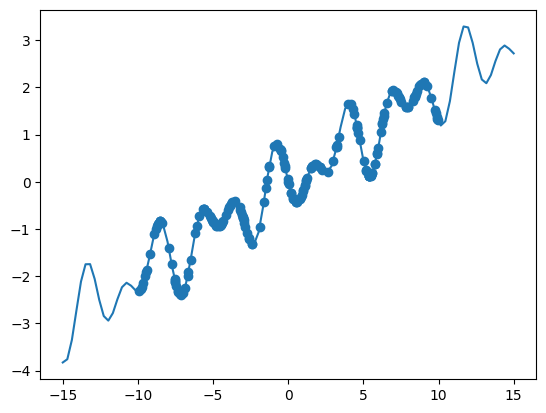

In [42]:
# The true function
def oscillator(x):
    return np.cos((x - 5) / 2) * np.sin(10 * x / 5) + x * 0.2


X = np.linspace(-15, 15, 100)[:, np.newaxis]
y = oscillator(X)  # Arrange outputs as feature columns

n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

plt.plot(X, y)
plt.scatter(X_data, y_data)
plt.show()

### ransforming our Random Data Points into a DataFrame
`twinLab` requires our data to be stored in a DataFrame, so we're converting the generated random data points into a pandas DataFrame. We use the `pd.DataFrame()` function to create a DataFrame object. This function takes a dictionary where keys are column names and values are the corresponding data arrays.

In this case, we're creating a DataFrame with two columns: "x" and "y". The "x" column contains the random input values, and the "y" column contains the corresponding output values.

Finally, we display the first few rows of the DataFrame using the `head()` method to ensure that the DataFrame has been created successfully. `head()` shows the first 5 rows of our DataFrame, which we have called `df`.

In [43]:
# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data})
df.head()

,x,y
0,-0.517119,0.693768
1,-2.929103,-0.866208
2,-6.888663,-2.260464
3,7.811658,1.576216
4,9.529268,1.773183


### Uploading the Dataset to the Cloud
So we can utilise our data, we prepare to upload the dataset to the cloud using `twinLab`.

First, we assign a string `"Example_Data"` to the variable `dataset_id`. This string represents the identifier for our dataset.

Next, we create a Dataset object using the `tl.Dataset()` constructor and pass `dataset_id` as an argument. This Dataset object provides functionalities to work with datasets.

Now, we upload the dataset to the cloud. The dataset we want to upload is represented by the DataFrame `df`. We use the `upload()` method of the Dataset object (dataset) to upload the DataFrame to the cloud. The `verbose=True` argument indicates that we want to see detailed information about the upload process.

In [44]:
# Define the name of the dataset
dataset_id = "Example_Data"

# Initialise a Dataset object
dataset = tl.Dataset(id=dataset_id)

# Upload the dataset to the cloud
dataset.upload(df, verbose=True)

Dataframe is uploading.
Processing dataset
Dataset Example_Data was processed.


### GP without autoML
We run a Gaussian Process with the Matern 5/2 kernel first. This kernel is the default kernel for Gaussian Process modelling in `twinLab`.

The Matérn 5/2 kernel is a popular choice in Gaussian Process regression for modeling spatial or temporal data. The Matérn 5/2 kernel is defined as:

$$ k(x, x') = \sigma^2 \left(1 + \frac{\sqrt{5}r}{\rho} + \frac{5r^2}{3\rho^2}\right) \exp\left(-\frac{\sqrt{5}r}{\rho}\right) $$

Where:
- $ \sigma^2 $ is the variance parameter,
- $ \rho $ is the lengthscale parameter,
- $ r = \|x - x'\| $ is the Euclidean distance between input points $ x $ and $ x' $.

The Matérn 5/2 kernel is characterised by its smoothness and differentiability. It allows for more flexibility in capturing complex patterns in data compared to simpler kernels. However, it still maintains some smoothness properties that prevent overfitting, making it a popular choice for various applications in machine learning and spatial statistics.


### Training a Gaussian Process Emulator with TwinLab

First, we set the identifier for our emulator by assigning the string `"BasicGP"` to the variable `emulator_id`.

Next, we create an Emulator object using `twinLab`. We use the `tl.Emulator()` constructor and pass the `emulator_id` as an argument to initialise the emulator.

We define the training parameters for our emulator using the `tl.TrainParams()` constructor. In this case, we set the ratio of training to testing data to 0.75 (indicating that 75% of the data will be used for training) and specify that we want to use Gaussian Process Regression as the estimator.

We train the emulator using the `train()` method of the Emulator object (emulator). We provide the dataset (dataset) that we prepared earlier, specify the input features as "x", the output targets as "y", the training parameters (params), and set `verbose=True` to display detailed information about the training process.

This process allows us to create a model that can predict output values based on input features using Gaussian Process Regression.

In [45]:
# Initialise emulator
emulator_id = "BasicGP"

emulator = tl.Emulator(id=emulator_id)

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=0.75, estimator="gaussian_process_regression"
)

# Train the mulator using the train method
emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=params, verbose=True
)

Model BasicGP has begun training.
Training complete!


### Visualising the Emulator Inference Results

Now, we are using the method `.plot()` to plot the data using the columns "x" and "y" from our dataset. We're also setting limits for the x-axis from -15 to 15.

Next, we're adding the training data points to our plot. We're telling the plot to scatter the points from our DataFrame. We're labeling these points as "Training data" and coloring them black. We're also adjusting the size of the dots to be 10 pixels.

Then, we're adding a legend to the plot to explain what the data represents.

After that, we're setting the title of the plot to be "Emulator Inference Results".

Finally, we're displaying the plot.

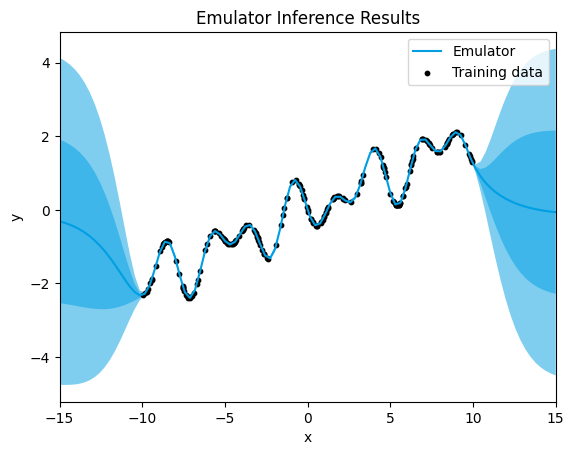

In [46]:
plt = emulator.plot("x", "y", x_lim=[-15,15])
plt.scatter(df["x"], df["y"], 
            label="Training data", 
            color="black",
            s=10  # Adjust the size of the dots as needed
            )
plt.legend()  # Add a legend
plt.title("Emulator Inference Results")
plt.show()

<div class="alert alert-note" role="alert">
Here, we observe a distinct pattern of uncertainty in the predictions. While there is minimal uncertainty around the training data points, indicating high confidence in the model's predictions within the observed data range, there is a notable increase in uncertainty outside of these data points.

</br>

The Matérn 5/2 kernel, being a versatile choice with a balance between smoothness and flexibility, typically provides accurate predictions around the training data points, capturing the underlying patterns effectively. However, as we move away from the observed data, the model's ability to make accurate predictions diminishes significantly. This results in predictions that deviate substantially from the true function in regions where the model lacks sufficient training data.

The high uncertainty observed outside of the data points indicates the model's limited confidence in its predictions in these regions. This uncertainty arises from the extrapolation nature of the Gaussian Process model, where the model attempts to predict values beyond the observed data range based on the learned patterns. In such cases, the model's predictions become increasingly unreliable as they move further away from the training data, leading to significant discrepancies between the predicted values and the true function.
</div>

### Evaluating the Emulator Performance
After running the emulator, it's essential to assess its performance using appropriate metrics. 

`twinLab` provides a convenient method, `emulator.score()`, to accomplish this task. By default, this function calculates the mean square error (MSE), offering insights into the accuracy of the emulator's predictions compared to the actual data.

To evaluate the performance of our emulator, we can simply call `emulator.score()` after training the model. This will provide us with a quantitative measure of how well the emulator is capturing the underlying patterns in the data.

In [47]:
emulator.score()

[1.6452359065186406e-06]

Despite the observed uncertainty outside of the training data points, the mean squared error (MSE) remains remarkably low.

This low MSE suggests that, on average, the squared difference between the model's predictions and the actual data values is extremely small. Despite the challenges associated with extrapolation and the model's limited ability to make accurate predictions outside of the training data range, the MSE indicates that the model's overall performance is highly accurate within the observed data range.

The discrepancy between the MSE and the visual observation of uncertainty and inaccuracies outside of the training data points highlights an important aspect of Gaussian Process regression. While the MSE provides a quantitative measure of the model's predictive accuracy, it may not always capture the full extent of uncertainty or capture the model's behavior in regions where it lacks sufficient training data.

<div class="alert alert-note" role="alert">
While the MSE suggests excellent predictive accuracy within the observed data range, it's essential to interpret this metric in conjunction with visual observations of uncertainty and performance outside of the training data points to gain a comprehensive understanding of the model's behavior and limitations.
</div>

--------

## Trying Other Kernels
In certain scenarios, it's advantageous to pre-select the kernel for the Gaussian Process used in modelling. This could be due to the user's prior belief about the nature of the underlying process, such as assuming linearity, accounting for periodic behaviour at varying length-scales, or explicitly addressing short-time noise in the data.

The `Emulator` class in TwinLab offers a solution for this by providing the argument `covar_module` within `estimator_params`. Currently, the available kernels are represented as 3-character uppercase strings, each serving a specific modeling purpose:

- `"LIN"`: Linear kernel
- `"M12"`: Matern 1/2 kernel
- `"M32"`: Matern 3/2 kernel
- `"M52"`: Matern 5/2 kernel
- `"PER"`: Periodic kernel
- `"RBF"`: Radial Basis Function kernel
- `"RQF"`: Rational Quadratic Kernel

Moreover, users can compose kernels using brackets and the `+` or `*` string operators, allowing for more intricate kernel combinations. For instance:

- `"LIN+PER"`
- `"(M52*PER)+RQF"`

This flexibility empowers users to tailor the kernel to their specific modeling needs, enhancing the versatility and effectiveness of Gaussian Process regression in diverse applications.

### Linear Kernel
The linear kernel is a simple kernel function that models linear relationships between input features and output values. It is defined as:

$$ k_{\text{LIN}}(x, x') = x^T x' $$

where $x$ and $x'$ are input feature vectors. 

The linear kernel captures linear trends in the data, allowing the GP model to learn linear relationships between input features and output values. It is particularly useful when the underlying relationship between the input and output variables is expected to be linear or close to linear.

Let's observe the outcome when applying a linear kernel in this specific example, mirroring the sequential steps previously employed:

In [48]:
# Initialise emulator
emulator_id = "LinearGP"

linear_emulator = tl.Emulator(id=emulator_id)

# Define the estimator params with a covariance function
estimator_params = tl.EstimatorParams(covar_module="LIN")

# Define the training parameters for your emulator
params = tl.TrainParams(
    train_test_ratio=0.75,
    estimator="gaussian_process_regression",
    estimator_params=estimator_params,
)

# Train the emulator using the defined parameters
linear_emulator.train(dataset=dataset, inputs=["x"], outputs=["y"], params=params)

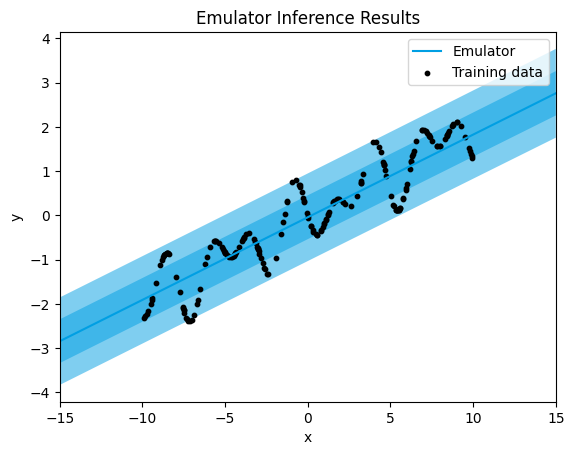

In [49]:
plt = linear_emulator.plot("x", "y", x_lim=[-15,15])
plt.scatter(df["x"], df["y"], 
            label="Training data", 
            color="black",
            s=10  # Adjust the size of the dots as needed
            )
plt.legend()  # Add a legend
plt.title("Emulator Inference Results")
plt.show()

In [50]:
linear_emulator.score()

[0.25294527270809253]

<div class="alert alert-note" role="alert">
As anticipated, a significant band of uncertainty is evident in the predictions, and the mean squared error (MSE) is notably high. This outcome arises due to the absence of a linear pattern in the data, rendering the linear kernel unsuitable for accurately fitting the data. The linear kernel operates under the assumption of a linear relationship between the input features and output values. Consequently, when this assumption doesn't hold true, the model struggles to capture the underlying patterns in the data, resulting in a less precise fit and higher quantification of uncertainty.
</div>

## Matérn Kernel 1/2
The Matérn 1/2 kernel is a commonly used kernel function in Gaussian Process modelling. It is defined as:

$$ k_{\text{M1/2}}(x, x') = \exp(-r) $$

where $ r $ is the Euclidean distance between input points $ x $ and $ x'$. In other words, it assigns higher similarity to input points that are closer to each other in the input space and lower similarity to points that are farther apart.

The Matérn 1/2 kernel is characterised by its smoothness and flexibility. It is often used when the underlying function being modeled is expected to exhibit rough or erratic behavior. Compared to other Matérn kernels, the Matérn 1/2 kernel has less smoothness and a shorter range of correlation, making it suitable for capturing abrupt changes or sharp transitions in the data.

In practice, the Matérn 1/2 kernel is a popular choice in scenarios where the underlying data exhibits discontinuities or rapid fluctuations, such as in time series analysis or spatial modeling. It provides a balance between flexibility and computational efficiency, making it a versatile option for various regression tasks in machine learning and statistical modeling.

<div class="alert alert-info" role="alert">To streamline our workflow and avoid code duplication, we create a function that trains the model with a selected kernel. This function also generates visualisations of the emulator inference results and provide performance metrics. This way we can efficiently train multiple models with different kernels while maintaining a clear and organised code structure.
</div>

In [51]:
def emulator_kernel_selection(code_kernel):
    # Initialise emulator
    emulator_id = code_kernel

    emulator = tl.Emulator(id=emulator_id)

    # Define the estimator params with a covariance function
    estimator_params = tl.EstimatorParams(covar_module=code_kernel)

    # Define the training parameters for your emulator
    params = tl.TrainParams(
        train_test_ratio=0.75,
        estimator="gaussian_process_regression",
        estimator_params=estimator_params,
    )

    # Train the emulator using the defined parameters
    emulator.train(dataset=dataset, inputs=["x"], outputs=["y"], params=params)

    plt = emulator.plot("x", "y", x_lim=[-15,15])
    plt.scatter(df["x"], df["y"], 
                label="Training data", 
                color="black",
                s=10  # Adjust the size of the dots as needed
                )
    plt.legend()  # Add a legend
    plt.title("Emulator Inference Results")
    plt.show()

    score = emulator.score()

    return score

→ Let's see what happens when we choose the Matérn 1/2 kernel:

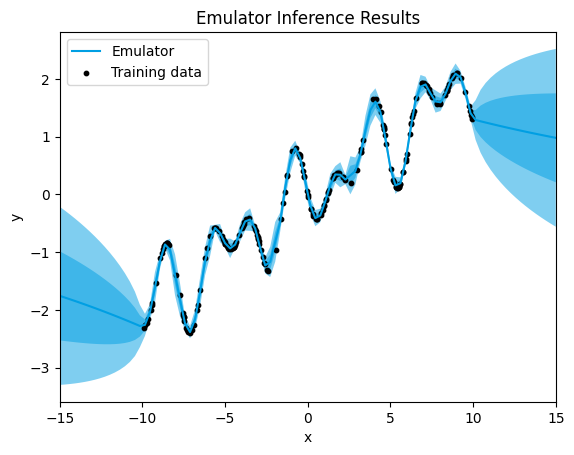

[0.0019470087938077273]

In [52]:
emulator_kernel_selection("M12")

<div class="alert alert-note" role="alert">
In the case of the Matérn 1/2 kernel, we observe a presence of uncertainty surrounding certain training data points, along with a lower mean squared error (MSE) value compared to the linear kernel. This reduction in MSE compared to the linear kernel suggests an improved fit of the model to the data.

The Matérn 1/2 kernel offers a more flexible modeling approach compared to the linear kernel, allowing for capturing some degree of nonlinearity in the data. While the uncertainty around certain data points indicates the model's acknowledgment of variability and noise in the data, the lower MSE suggests a better overall fit to the underlying patterns in the data.

Despite the presence of uncertainty, the Matérn 1/2 kernel demonstrates an enhanced capability to capture the inherent complexities within the data, resulting in more accurate predictions and a reduced error compared to the linear kernel.
</div>

### Matérn Kernel 3/2
The Matérn 3/2 kernel is another widely used kernel function in Gaussian Process modelling. It is defined as:

$$ k_{\text{M3/2}}(x, x') = \left(1 + \frac{{\sqrt{3}r}}{\ell}\right) \exp\left(-\frac{{\sqrt{3}r}}{\ell}\right) $$

where $ r $ is the Euclidean distance between input points $x$ and $ x' $, and $ \ell $ is the length-scale parameter.

The Matérn 3/2 kernel is characterised by its smoothness and flexibility, falling between the Matérn 1/2 and Matérn 5/2 kernels in terms of smoothness and range of correlation. It is often used when the underlying function being modeled exhibits moderate smoothness and some degree of roughness or variability.

Compared to the Matérn 1/2 kernel, the Matérn 3/2 kernel provides a smoother representation of the underlying function, making it suitable for capturing gradual changes and moderate fluctuations in the data. It strikes a balance between capturing detailed patterns and avoiding overfitting to noisy or sparse data.

In practice, the Matérn 3/2 kernel is commonly employed in modelling tasks where the underlying data exhibits moderate variability and smoothness, such as in geostatistical modeling, environmental data analysis, or modeling physical processes with spatial or temporal dependencies. Its flexibility and adaptability make it a versatile choice for a wide range of applications in machine learning and statistical modeling.

→ Let's see what happens when we choose the Matérn 3/2 kernel for our running example:

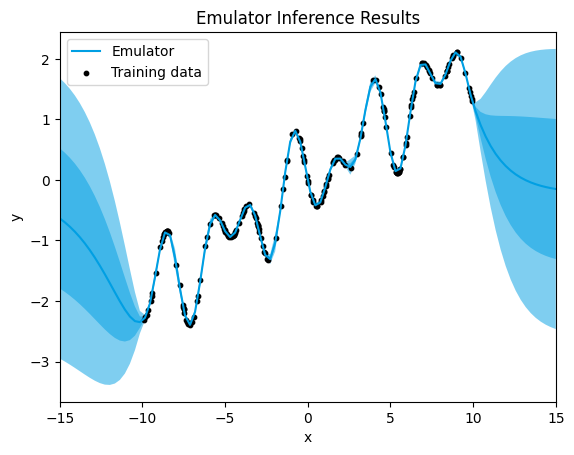

[3.0447758008875315e-05]

In [53]:
emulator_kernel_selection("M32")

<div class="alert alert-note" role="alert"> With the Matérn 3/2 kernel, we observe a further reduction in the quantification of uncertainty around the training data points, accompanied by an even lower mean squared error (MSE) value. This significant decrease in both uncertainty and MSE compared to the Matérn 1/2 kernel indicates an improved fit and predictive accuracy of the model.

The Matérn 3/2 kernel offers increased flexibility in modeling nonlinear relationships compared to the Matérn 1/2 kernel, allowing for a more nuanced representation of the underlying patterns in the data. As a result, the model can better capture the complexities present in the data, leading to more precise predictions and a reduced error.

The decreased uncertainty around the training data points suggests a higher confidence in the model's predictions, indicating a better alignment between the model's estimates and the actual data values. This improvement in both uncertainty quantification and MSE highlights the effectiveness of the Matérn 3/2 kernel in accurately capturing the underlying structure of the data.
</div>

### Periodic
The periodic kernel is a kernel function commonly used in Gaussian Process modelling in order to model periodic patterns in the data. It is defined as:

$$ k_{\text{PER}}(x, x') = \exp\left(-2 \sin^2\left(\frac{\pi \|x - x'\|}{p}\right)\right) $$

where $ \|x - x'\| $ is the Euclidean distance between input points $x$ and $x'$, and $p$ is the periodicity parameter.

The periodic kernel captures periodic variations in the data by assigning higher similarity to input points that are close to each other in the input space and have similar periodic behaviour. It effectively models functions that repeat at regular intervals, such as seasonal trends, cyclic phenomena, or periodic signals.

Compared to other kernels like the Matérn kernels or the radial basis function (RBF) kernel, the periodic kernel explicitly incorporates periodicity into the modeling process. This makes it particularly useful in scenarios where the underlying data exhibits periodic patterns or cyclic behavior, such as in time series analysis, signal processing, or seasonal forecasting.

In practice, the periodic kernel is applied in modelling tasks where the underlying data displays periodicity and the goal is to accurately capture and predict the periodic behaviour of the underlying process. Its ability to model periodic patterns with high fidelity makes it a valuable tool in various fields, including finance, climate science, and engineering.

→ Let's see what happens when we choose the perioduc kernel for our running example:

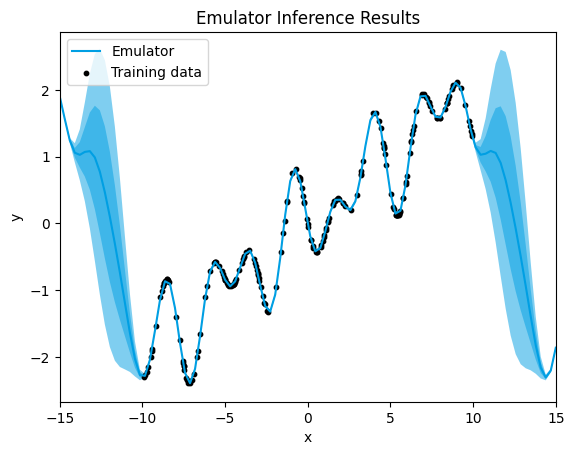

[1.272644945270839e-06]

In [54]:
emulator_kernel_selection("PER")

<div class="alert alert-note" role="alert">
When using the periodic kernel, we observe that the quantification of uncertainty around the training data points is decreased, with almost no noticeable uncertainty, and the mean squared error (MSE) is lower.

The periodic kernel is specifically designed to model periodic patterns in the data, making it highly effective at capturing repetitive trends or cyclical behavior. 

As a result, the decreased uncertainty around the training data points indicates a higher confidence in the model's predictions, with the model exhibiting a stronger alignment with the observed data. The lower MSE further confirms the increased accuracy of the model, suggesting that it is more effectively capturing the nature of the data compared to the Matérn kernels in this case.
</div>

### RBF Kernel
The Radial Basis Function (RBF) kernel, also known as the squared exponential kernel or Gaussian kernel, is a fundamental kernel function used in Gaussian Process modelling. It is defined as:

$$ k_{\text{RBF}}(x, x') = \exp\left(-\frac{{\|x - x'\|^2}}{{2\ell^2}}\right) $$

where $ \|x - x'\| $ is the Euclidean distance between input points $x$ and $x'$, and $ \ell $ is the length-scale parameter.

The RBF kernel captures smooth variations in the data by assigning higher similarity to input points that are close to each other in the input space. It effectively models functions with smooth and continuous behavior, making it suitable for capturing gradual changes and correlations between input features.

Compared to other kernels like the Matérn kernels or the periodic kernel, the RBF kernel offers a balance between flexibility and smoothness. It is often used in modelling tasks where the underlying function being modeled exhibits smoothness and continuity, such as in spatial modeling, function approximation, or interpolation.

In practice, the RBF kernel is widely applied in various fields, including machine learning, geostatistics, and physics. Its versatility and effectiveness in capturing complex patterns and correlations in the data make it a popular choice for Gaussian Process modelling in a wide range of applications.

→ Let's see what happens when we choose the RBF kernel for our running example:

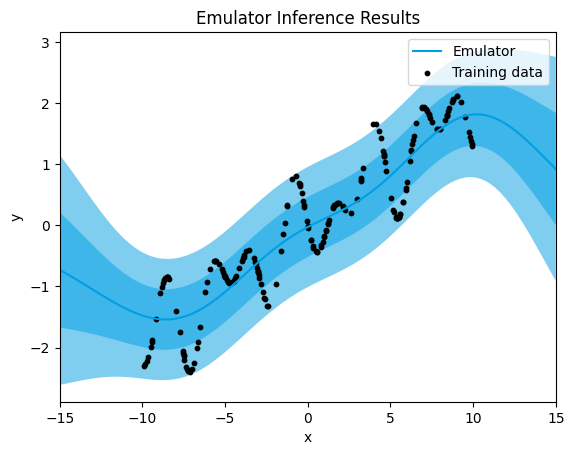

[0.26709564150193155]

In [55]:
emulator_kernel_selection("RBF")

<div class="alert alert-note" role="alert">When employing the Radial Basis Function (RBF) kernel, we observe a significant band of uncertainty surrounding the training data points, accompanied by a higher mean squared error (MSE) value.

The large band of uncertainty indicates that the model lacks confidence in its predictions, especially in regions of the input space where there are no or few training data points. This uncertainty arises from the inherent smoothness of the RBF kernel, which assigns similar function values to nearby input points, leading to a wide range of possible predictions.

Furthermore, the higher MSE suggests that the model's predictions deviate more from the actual data values compared to other kernels, indicating a less accurate fit to the underlying patterns in the data. This discrepancy between predicted and actual values contributes to the overall higher error observed with the RBF kernel.
</div>

### RQF Kernel
The Rational Quadratic (RQF) kernel is another kernel function used in Gaussian Process modeling. It is defined as:

$$ k_{\text{RQF}}(x, x') = \left(1 + \frac{{\|x - x'\|^2}}{{2\alpha \ell^2}}\right)^{-\alpha} $$

where $ \|x - x'\| $ is the Euclidean distance between input points $ x $ and $ x' $, $ \ell $ is the length-scale parameter, and $ \alpha $ is the scale mixture parameter.

The RQF kernel captures both short-term and long-term dependencies in the data by combining multiple RBF kernels with different characteristic length scales. This allows it to model functions with a mixture of smooth and non-smooth behavior, making it suitable for capturing complex patterns and correlations in the data.

Compared to other kernels like the RBF kernel or the Matérn kernels, the RQF kernel offers increased flexibility and adaptability. It is often used in modelling tasks where the underlying function being modeled exhibits a combination of smooth and non-smooth variations, such as in time series analysis, financial modeling, or biological data analysis.

In practice, the RQF kernel is applied in various fields where the underlying data displays mixed patterns of correlation and variability. Its ability to capture both short-term and long-term dependencies makes it a valuable tool in Gaussian Process modelling for capturing complex real-world phenomena.

→ Let's see what happens when we choose the RQF for our running example:

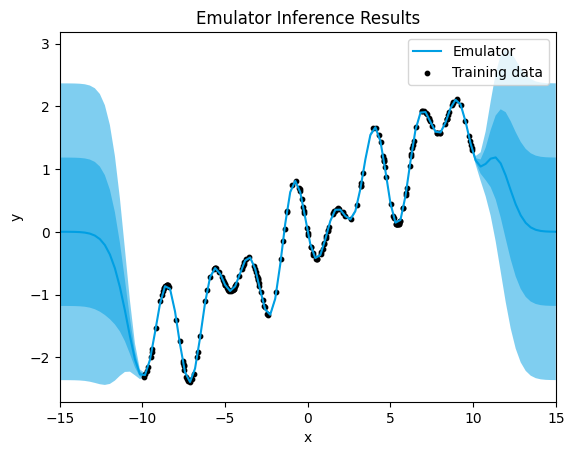

[1.3255072099185522e-06]

In [56]:
emulator_kernel_selection("RQF")

<div class="alert alert-note" role="alert">
When using the Rational Quadratic (RQF) kernel, we notice a significant decrease in uncertainty around training data points. Alongside this reduction in uncertainty, there's a noticeable decrease in the mean squared error (MSE).

The RQF kernel is adept at capturing both short-term and long-term patterns in the data, making it great for modeling changes over time. Its flexibility allows it to adapt to different scales of variation, helping it understand the underlying patterns in the dataset better.
</div>

-----------

## Gaussian Process with AutoML

Now, let's explore AutoML within TwinLab. This feature autonomously identifies the optimal kernel for your dataset. With TwinLab, users are relieved of the need to manually choose a kernel; instead, the platform utilises sophisticated model selection techniques to choose the kernel that most suitably aligns with the data.

AutoML in `twinlab` is exposed via the `'model_selection'=True` parameter in the `TrainParams` object. Additional parameters to control the model selection process can be passed to the `'model_selection_params'` parameter which accepts an instantiation of the `ModelSelectionParams` object.

`ModelSelectionParams` object contains all the parameters required for the model selection process. This includes:
- `'depth'`, which controls the maximum number of compositional kernels to search for, and 
- `'beam'`, which controls the number of successful trials carried between search iterations. `'beam'=1` corresponds to greedy search, and `'beam'=None` corresponds to grid search (this is the default, but will result in exponential computational complexity). 

It is highly recommended to also provide a `'seed'` keyword parameter to allow reproducibility.


### Utilising AutoML for Model Selection with TwinLab

We begin by initialising an emulator object specifically for AutoML, setting the identifier for this emulator as `"autoMLGP"`. This emulator will be used for automatic kernel selection.

We specify the parameters for the kernel selection process using the `ModelSelectionParams` object. This includes setting the 'depth' parameter to 4, controlling the maximum number of compositional kernels to search for, the 'beam' parameter to 2, which controls the number of successful trials carried between search iterations, and the 'seed' parameter to 123 which allows for reproducibility.

We define the training parameters for the emulator, specifying that we want to enable model selection (`model_selection=True`) and providing the `model_selection_params` we defined earlier. Additionally, we set other parameters such as the train-test split ratio and the estimator to be used (in this case, Gaussian Process Regression).

Finally, we train the emulator using the train() method, passing the dataset, input features, output target, and the defined training parameters (new_params). We set `verbose=True` to display detailed information about the training process.

With this code, we utilise AutoML capabilities provided by `twinLab` to automatically select the best kernel for our dataset. We define the model selection parameters, enable model selection during training, and then train the emulator using the specified parameters.

In [57]:
# Initialise emulator
emulator_id = "autoMLGP"

model_selection_emulator = tl.Emulator(id=emulator_id)

# Define the model selction parameters
model_selection_params = tl.ModelSelectionParams(depth=4, beam=2, seed=123)

# Define the training parameters for your emulator
new_params = tl.TrainParams(
    model_selection=True,
    model_selection_params=model_selection_params,
    train_test_ratio=0.75,
    estimator="gaussian_process_regression",
)

# Train the emulator using the train method
model_selection_emulator.train(
    dataset=dataset, inputs=["x"], outputs=["y"], params=new_params, verbose=True
)

Model autoMLGP has begun training.
Training complete!


But how do we know what kernel has been chosen? We can use `emulator.summarise()`.

In [58]:
model_selection_emulator.summarise()

{'transformer_diagnostics': [],
 'estimator_diagnostics': {'covar_module': 'AdditiveKernel(\n  (kernels): ModuleList(\n    (0): PeriodicKernel(\n      (lengthscale_prior): GammaPrior()\n      (raw_lengthscale_constraint): Positive()\n      (period_length_prior): GammaPrior()\n      (raw_period_length_constraint): Positive()\n    )\n    (1): RBFKernel(\n      (lengthscale_prior): GammaPrior()\n      (raw_lengthscale_constraint): Positive()\n    )\n    (2): LinearKernel(\n      (variance_prior): GammaPrior()\n      (raw_variance_constraint): Positive()\n    )\n  )\n)',
  'mean_module': 'ConstantMean()',
  'likelihood.noise_covar.raw_noise': [9.99999975e-05],
  'likelihood.noise_covar.noise_prior.concentration': 1.100000023841858,
  'likelihood.noise_covar.noise_prior.rate': 0.05000000074505806,
  'likelihood.noise_covar.raw_noise_constraint.lower_bound': 9.999999747378752e-05,
  'likelihood.noise_covar.raw_noise_constraint.upper_bound': 'array(inf)',
  'mean_module.raw_constant': 0.13426

<div class="alert alert-note" role="alert">
From the resulst, we can see that a compisiional kernel has been chosen, in particular, an addittion of a Periodic kernel and a RFB kernel.
</div>

Now, let's visalise the emulator inference results uisng `.plot()`:

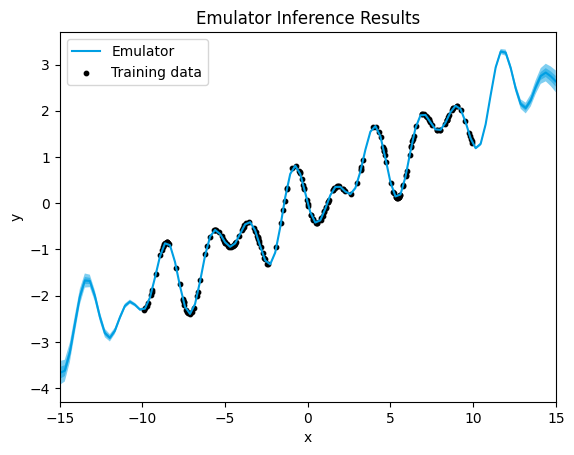

In [59]:
plt = model_selection_emulator.plot("x", "y", x_lim=[-15,15])
plt.scatter(df["x"], df["y"], 
            label="Training data", 
            color="black",
            s=10  # Adjust the size of the dots as needed
            )
plt.legend()  # Add a legend
plt.title("Emulator Inference Results")
plt.show()

In the plot, we see a clear alignment between the predicted data points and the underlying function. This suggests that the model's predictions closely match the actual data, even in regions where no training data was available, the quantification of uncertaininty is the lowest we have seen so far.

The lack of noticeable uncertainty around training data, and very low uncertainity in regions with no training data, suggests that the model is making predictions with high confidence and precision. GPs are probabilistic models that not only provide point predictions but also estimate the uncertainty associated with those predictions. When the uncertainty is not noticeable, it implies that the variance of the predictive distribution, as estimated by the GP, is low.

In other words, the GP is confident in its predictions and provides outputs that closely follow the underlying function, even in areas where it has not been explicitly trained. This indicates that the GP is effectively capturing the underlying patterns and relationships in the data, allowing it to make reliable predictions across the entire input space.

<div class="alert alert-note" role="alert">
This plot suggests that the GP model is performing well and is able to make accurate predictions with high confidence.
</div>


Same as we did before, we can assess the emulator perfomance by using `model_selection_emulator.score()`.

In [60]:
model_selection_emulator.score()

[1.3538397608789019e-07]

We observe that the Gaussian Process (GP) model's predictions exhibit extremely small errors on average. This indicates that our model's performance is excellent, demonstrating minimal deviation between the actual target values and the predictions it generates. Therefore, we can conclude that the GP model using AutoML effectively captures the underlying patterns in the data and makes highly accurate predictions.

## Cleanup: Deleting Emulators and Dataset
With `emulator.delete()`, we remove the emulator object that we previously created. This action ensures that any resources associated with this emulator, such as trained models or metadata, are cleared from memory or storage.
Similarly, `model_selection_emulator.delete()` deletes the emulator object used for AutoML model selection. This step ensures that any resources related to this emulator are also cleaned up.

Using `dataset.delete()`, we remove the dataset object that we created and used for training the emulators. By deleting this dataset, we free up resources and prevent it from being accessible for further analysis or training.

Deleting these objects, allows us to perform cleanup tasks to ensure that no unnecessary resources are retained in memory or storage after we've finished using the emulators and dataset. This practice helps optimise resource usage and prevents memory leaks.

In [61]:
# Delete emulators and dataset
emulator.delete()
model_selection_emulator.delete()

dataset.delete()